# Prototype for MC matching based on minimum angle between genParticle and pfcharged

In this example, `ak.cartesian()` is used to make pairs of MC-truth generated particles (from `genParticles`) and reconstructed hadrons (from `pfcharged`). A cut is applied on the `pdgId` such that only pairs with the same generator and reco `pdgId` are considered. The cosine of the angle between the generated and reco particles is calculated, and used as a metric for picking the best pair. The generated information is then associated to the reco information for each reco hadron, allowing quantities like $\delta(p)$ to be calculated. 

The code is based on the example found in [this](https://github.com/jpivarski-talks/2020-04-08-eic-jlab/blob/master/2020-04-08-eic-jlab-EVALUATED.ipynb) `awkward array` tutorial, where brem photons are associated to electrons. 

In [79]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open(f"{loc.DATA}/FCCDelphesOutput.root")
tree = file['events']

Get the reconstructed stable hadrons:

In [80]:
h_container = "efcharged.core"
h = tree.arrays(filter_name=f"{h_container}*",how="zip")
h[h_container,'p4.p'] = kinematics.calc_p(h,h_container)

Get the generated particles:

In [81]:
g_container = "genParticles.core"
g = tree.arrays(filter_name=f"{g_container}*",how="zip")
g[g_container,'p4.p'] = kinematics.calc_p(g,g_container)

Make pairs of reco and gen particles across all events:

In [82]:
pairs = ak.cartesian({"reco": h[h_container], "gen": g[g_container]}, nested=True)

Require that the `pdgId` of the particles are the same:

In [83]:
ID_cut = pairs["reco","pdgId"] == pairs["gen","pdgId"]
pairs = pairs[ID_cut]

Calculate $\cos(\theta)$ between the reco and true particles, which we will use as a matching requirement:

In [84]:
pairs["costheta"] = kinematics.cos_angle(pairs["reco"], pairs["gen"])

Pick best pair according to $\cos(\theta)_{max}$ i.e. minimum angle:

In [85]:
best_pair = pairs[ak.singletons(ak.argmax(pairs["costheta"], axis=2))]

Associate the best gen particle with the reco particle:

In [86]:
h["match"] = ak.firsts(best_pair, axis=2)

Can get the reco info using `h["match","reco","var_name"]` and the corresponding MC-truth value with `h["match","gen","var_name"]`. So can calculate a resolution like this:

In [87]:
h["delta_p"] = h["match","reco","p4.p"] - h["match","gen","p4.p"]
h["delta_p_per"] = h["delta_p"] / h["match","reco","p4.p"]

Remove some outliers to get a sensible measure of the width:

In [88]:
max_val = 0.01
h = h[abs(h["delta_p_per"]) < max_val]
delta_p_mu = np.mean(ak.flatten(h["delta_p_per"]))
print(f"Momentum resolution mu = {delta_p_mu:.4f}")
delta_p_sigma = np.std(ak.flatten(h["delta_p_per"]))
print(f"Momentum resolution sigma = {delta_p_sigma:.4f}")

Momentum resolution mu = -0.0000
Momentum resolution sigma = 0.0021


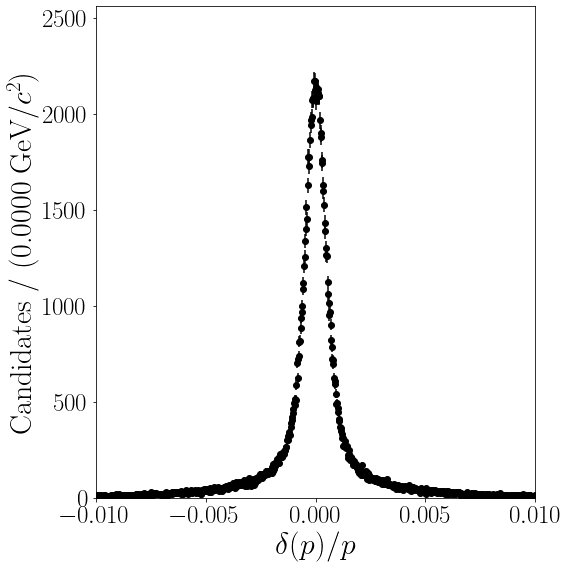

In [89]:
plotting.errorbar_hist(h,"delta_p_per","all_hadrons","$\delta(p)/p$",-max_val,max_val)

We can also look at the momentum resolution as a function of momentum, by splitting the sample into $p$ bins and plotting the average $\delta(p)/p$ in each bin. We make some bins, then calculate the bin centres and put them into `p_vals`. We then cut on the hadrons so that we keep only the ones in a certain bin using `h_bin_cut`, and then calculate the standard deviation of the $\delta(p)/p$ values in that bin. These are stored in `delta_p_per_vals`. We can then plot these values as a function of $p$.

In [90]:
n_bin_edges = 21
p_min = 0.5
p_max = 15.
bins = np.linspace(p_min, p_max, n_bin_edges)

delta_p_per_vals = []
p_vals = []
for i in range(0,len(bins)-1):
    p_vals.append(bins[i] + 0.5*(bins[i+1] - bins[i]))
    h_bin_cut = np.logical_and(h[h_container,'p4.p'] >= bins[i], h[h_container,'p4.p'] < bins[i+1])
    h_bin = h[h_bin_cut]
    delta_p_per_vals.append(100*np.std(ak.flatten(h_bin["delta_p_per"])))

Now to plot the momentum resolution as a function of momentum

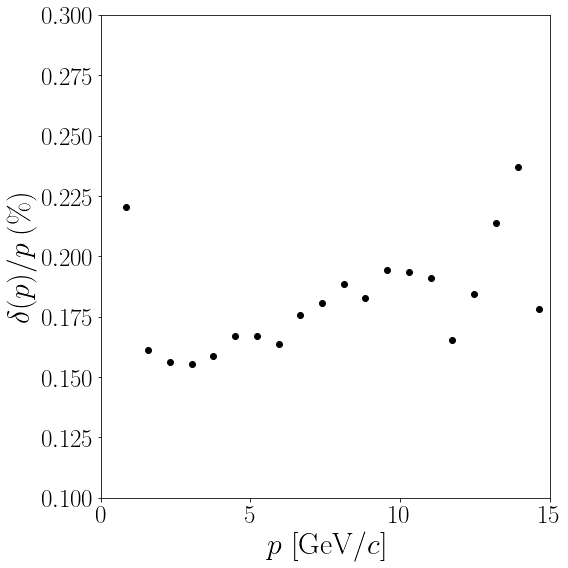

In [91]:
plotting.errorbar_plot(p_vals, 
                       delta_p_per_vals, 
                       "p", 
                       "delta_p_per", 
                       "$p$ [GeV/$c$]", 
                       "$\delta(p)/p$ ($\%$)", 
                       [0.,p_max], 
                       [0.1,0.3], 
                       x_err=None, 
                       y_err=None)